# 5-Minute Tutorial: Getting Started

Welcome to ``brainpy.state.state``! This quick tutorial will get you up and running with your first neural simulation in just a few minutes.

## What You'll Learn

- How to create neurons
- How to build simple networks
- How to run simulations
- How to visualize results

## Step 1: Import Libraries

First, let's import the necessary libraries:

In [3]:
import jax

import brainpy
import brainstate
import brainunit as u
import braintools
import matplotlib.pyplot as plt


## Step 2: Create Your First Neuron

Let's create a simple Leaky Integrate-and-Fire (LIF) neuron:

In [4]:
# Set simulation time step
brainstate.environ.set(dt=0.1 * u.ms)

# Create a single LIF neuron
neuron = brainpy.state.LIF(
    1,
    V_rest=-65. * u.mV,      # Resting potential
    V_th=-50. * u.mV,        # Spike threshold
    V_reset=-65. * u.mV,     # Reset potential
    tau=10. * u.ms,          # Membrane time constant
)

print("Created a LIF neuron!")

Created a LIF neuron!


## Step 3: Simulate the Neuron

Now let's inject a constant current and see how the neuron responds:

In [8]:
# Initialize neuron state
brainstate.nn.init_all_states(neuron)

# Define simulation parameters
duration = 200. * u.ms
dt = brainstate.environ.get_dt()
times = u.math.arange(0. * u.ms, duration, dt)

# Input current (constant)
I_input = 2.0 * u.nA

# Run simulation and record membrane potential
def step_run(t):
    with brainstate.environ.context(t=t):
        neuron(I_input)
        return neuron.V.value, neuron.get_spike()

voltages, spikes = brainstate.transform.for_loop(step_run, times)

print(f"Simulation complete! Recorded {len(times)} time steps.")

Simulation complete! Recorded 2000 time steps.


## Step 4: Visualize the Results

Let's plot the membrane potential over time:

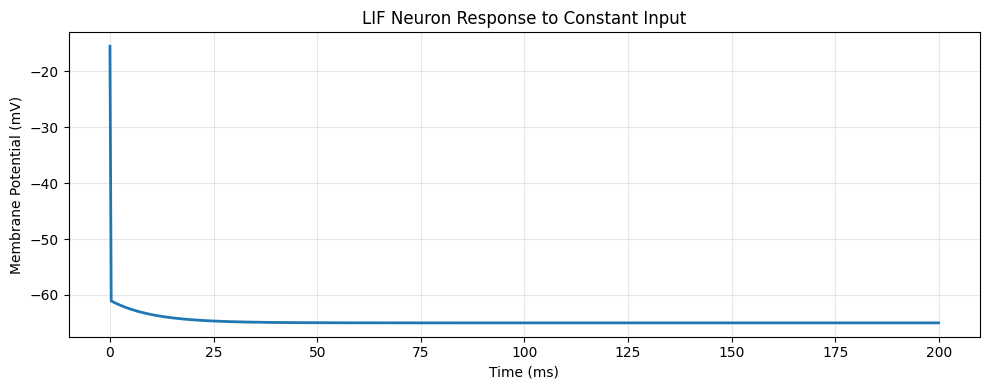

Number of spikes: 3
Average firing rate: 15.00 Hz


In [9]:
# Convert to appropriate units for plotting
times_plot = times.to_decimal(u.ms)
voltages_plot = voltages.to_decimal(u.mV)

# Create plot
plt.figure(figsize=(10, 4))
plt.plot(times_plot, voltages_plot, linewidth=2)
plt.xlabel('Time (ms)')
plt.ylabel('Membrane Potential (mV)')
plt.title('LIF Neuron Response to Constant Input')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Count spikes
n_spikes = int(u.math.sum(spikes != 0))
firing_rate = n_spikes / (duration.to_decimal(u.second))
print(f"Number of spikes: {n_spikes}")
print(f"Average firing rate: {firing_rate:.2f} Hz")

## Step 5: Create a Network of Neurons

Now let's create a small network with excitatory and inhibitory populations:

In [10]:
class SimpleEINet(brainstate.nn.Module):
    def __init__(self, n_exc=80, n_inh=20):
        super().__init__()
        self.n_exc = n_exc
        self.n_inh = n_inh
        self.num = n_exc + n_inh
        
        # Create neurons
        self.neurons = brainpy.state.LIF(
            self.num,
            V_rest=-65. * u.mV,
            V_th=-50. * u.mV,
            V_reset=-65. * u.mV,
            tau=10. * u.ms,
            V_initializer=braintools.init.Normal(-65., 5., unit=u.mV)
        )
        
        # Excitatory to all projection
        self.E2all = brainpy.state.AlignPostProj(
            comm=brainstate.nn.EventFixedProb(n_exc, self.num, 0.1, 0.6*u.mS),
            syn=brainpy.state.Expon.desc(self.num, tau=2. * u.ms),
            out=brainpy.state.CUBA.desc(),
            post=self.neurons,
        )
        
        # Inhibitory to all projection
        self.I2all = brainpy.state.AlignPostProj(
            comm=brainstate.nn.EventFixedProb(n_inh, self.num, 0.1, -5.0*u.mS),
            syn=brainpy.state.Expon.desc(self.num, tau=2. * u.ms),
            out=brainpy.state.CUBA.desc(),
            post=self.neurons,
        )
    
    def update(self, input_current):
        # Get spikes from previous time step
        spikes = self.neurons.get_spike()
        
        # Update projections
        self.E2all(spikes[:self.n_exc])  # Excitatory spikes
        self.I2all(spikes[self.n_exc:])  # Inhibitory spikes
        
        # Update neurons
        self.neurons(input_current)
        
        return self.neurons.get_spike()

# Create network
net = SimpleEINet(n_exc=80, n_inh=20)
print(f"Created network with {net.num} neurons")

Created network with 100 neurons


## Step 6: Simulate the Network

Let's run the network and visualize its activity:

In [11]:
# Initialize network states
brainstate.nn.init_all_states(net)

# Simulation parameters
duration = 500. * u.ms
times = u.math.arange(0. * u.ms, duration, dt)
I_ext = 1.5 * u.nA  # External input current

# Run simulation
spike_history = brainstate.transform.for_loop(
    lambda t: net.update(I_ext),
    times,
    pbar=brainstate.transform.ProgressBar(10)
)

print("Network simulation complete!")

  0%|          | 0/5000 [00:00<?, ?it/s]

Network simulation complete!


## Step 7: Visualize Network Activity (Raster Plot)

Create a raster plot showing when each neuron fired:

In [14]:
import jax
spike_history = jax.block_until_ready(spike_history)

# Find spike times and neuron indices
t_indices, n_indices = u.math.where(spike_history != 0)

# Convert to plottable format
spike_times = times[t_indices].to_decimal(u.ms)

# Create raster plot
plt.figure(figsize=(12, 6))
plt.scatter(spike_times, n_indices, s=1, c='black', alpha=0.5)

# Mark excitatory and inhibitory populations
plt.axhline(y=net.n_exc, color='red', linestyle='--', alpha=0.5, label='E/I boundary')

plt.xlabel('Time (ms)', fontsize=12)
plt.ylabel('Neuron Index', fontsize=12)
plt.title('Network Activity (Raster Plot)', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)

# Add text annotations
plt.text(10, net.n_exc/2, 'Excitatory', fontsize=10, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
plt.text(10, net.n_exc + net.n_inh/2, 'Inhibitory', fontsize=10, bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))

plt.show()

# Calculate statistics
total_spikes = len(t_indices)
avg_rate = total_spikes / (net.num * duration.to_decimal(u.second))
print(f"Total spikes: {total_spikes}")
print(f"Average firing rate: {avg_rate:.2f} Hz")

Total spikes: 0
Average firing rate: 0.00 Hz


## Summary

Congratulations! 🎉 You've just:

1. ✅ Created individual neurons with physical units
2. ✅ Simulated neuron dynamics with input currents
3. ✅ Built a network with excitatory and inhibitory populations
4. ✅ Connected neurons with synaptic projections
5. ✅ Visualized network activity

## Next Steps

Now that you've completed your first simulation, you can:

- **Learn more concepts**: Read the [Core Concepts](../core-concepts/architecture.rst) guide
- **Follow tutorials**: Try the [Basic Tutorials](../tutorials/basic/01-lif-neuron.ipynb) for deeper understanding
- **Explore examples**: Check out the [Examples Gallery](../examples/gallery.rst) for real-world models
- **Experiment**: Modify the network parameters and see what happens!

### Try These Experiments

1. Change the connection probability in the network
2. Adjust the excitatory/inhibitory balance
3. Add more neuron populations
4. Try different input currents or patterns

Happy modeling! 🧠